# Cargue y preentrenamiento de datos

In [1]:
import os
from PIL import Image
import numpy as np
import random
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

def cargar_imagenes_con_etiquetas(ruta_dataset):
    imagenes = []
    etiquetas = []
    
    for etiqueta in os.listdir(ruta_dataset):
        carpeta = os.path.join(ruta_dataset, etiqueta)
        if os.path.isdir(carpeta):
            for archivo in os.listdir(carpeta):
                if archivo.endswith('.tif') or archivo.endswith('.png') or archivo.endswith('.jpg'):
                    img_path = os.path.join(carpeta, archivo)
                    img = Image.open(img_path)
                    imagenes.append(np.array(img)) 
                    etiquetas.append(etiqueta)
    
    return imagenes, etiquetas

def obtener_tamanios_por_etiqueta(imagenes, etiquetas):
    tamanios_por_etiqueta = {}
    for img, etiqueta in zip(imagenes, etiquetas):
        tamanio = img.shape[:2]
        if etiqueta not in tamanios_por_etiqueta:
            tamanios_por_etiqueta[etiqueta] = set()
        tamanios_por_etiqueta[etiqueta].add(tamanio)
    return tamanios_por_etiqueta

def redimensionar_imagenes(imagenes, nuevo_tamanio):
    imagenes_redimensionadas = []
    for img in imagenes:
        img_pil = Image.fromarray(img)
        img_redimensionada = img_pil.resize(nuevo_tamanio, Image.ANTIALIAS)
        imagenes_redimensionadas.append(np.array(img_redimensionada))
    return imagenes_redimensionadas

def verificar_tamanio(imagenes):
    tamanio_referencia = None
    for img in imagenes:
        if tamanio_referencia is None:
            tamanio_referencia = img.shape[:2]
        else:
            if img.shape[:2] != tamanio_referencia:
                return False
    return True

def normalizar_imagenes(imagenes):
    imagenes_array = np.array(imagenes)
    imagenes_normalizadas = imagenes_array / 255.0
    media = np.mean(imagenes_normalizadas, axis=(0, 1, 2))
    imagenes_normalizadas -= media
    return imagenes_normalizadas

def sobremuestrear_y_seleccionar(imagenes, etiquetas, n_samples=800):
    unique_labels = list(set(etiquetas))
    imagenes_sobremuestreadas = []
    etiquetas_sobremuestreadas = []

    for etiqueta in unique_labels:
        imagenes_de_etiqueta = [img for img, lbl in zip(imagenes, etiquetas) if lbl == etiqueta]
        
        if len(imagenes_de_etiqueta) < n_samples:
            # Sobremuestrear
            falta = n_samples - len(imagenes_de_etiqueta)
            imagenes_de_etiqueta.extend(random.choices(imagenes_de_etiqueta, k=falta))
        
        # Seleccionar 1000 imágenes aleatorias
        imagenes_de_etiqueta = random.sample(imagenes_de_etiqueta, n_samples)
        
        imagenes_sobremuestreadas.extend(imagenes_de_etiqueta)
        etiquetas_sobremuestreadas.extend([etiqueta] * n_samples)

    return imagenes_sobremuestreadas, etiquetas_sobremuestreadas


In [2]:
# Cargar y procesar las imágenes
ruta_dataset = 'C:/Users/nicol/Desktop/Universidad/Dataset_Utiles/Mixta_Propia_PatternNET'
imagenes, etiquetas = cargar_imagenes_con_etiquetas(ruta_dataset)

# Obtener tamaños por etiqueta antes de redimensionar
tamanios_por_etiqueta = obtener_tamanios_por_etiqueta(imagenes, etiquetas)
print(tamanios_por_etiqueta)

# Sobremuestrear y seleccionar
imagenes_sobremuestreadas, etiquetas_sobremuestreadas = sobremuestrear_y_seleccionar(imagenes, etiquetas, n_samples=800)


{'Baloncesto': {(255, 255), (256, 256)}, 'Campo de Futbol': {(4080, 4080), (255, 255), (256, 256)}, 'Cancha de Golf': {(256, 256)}, 'Cancha de Multiple': {(4080, 4080), (255, 255), (256, 256)}, 'Parque': {(255, 255), (256, 256)}, 'Tenis': {(255, 255), (256, 256)}}


In [3]:
# Redimensionar las imágenes si es necesario
if not verificar_tamanio(imagenes_sobremuestreadas):
    nuevo_tamanio = (256, 256)  # Ejemplo de nuevo tamaño
    imagenes_sobremuestreadas = redimensionar_imagenes(imagenes_sobremuestreadas, nuevo_tamanio)

# Normalizar las imágenes
imagenes_normalizadas = normalizar_imagenes(imagenes_sobremuestreadas)

# Listo para usar las imágenes normalizadas y etiquetas para tu modelo
print(f'Total de imágenes después de sobremuestreo y selección: {len(imagenes_normalizadas)}')
print(f'Total de etiquetas después de sobremuestreo y selección: {len(etiquetas_sobremuestreadas)}')

C:\Users\nicol\AppData\Local\Temp\ipykernel_16144\3464314544.py:37: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img_redimensionada = img_pil.resize(nuevo_tamanio, Image.ANTIALIAS)


Total de imágenes después de sobremuestreo y selección: 4800
Total de etiquetas después de sobremuestreo y selección: 4800


In [4]:
# Codificar las etiquetas
codificacion = {'Baloncesto': 0, 'Campo de Futbol': 1, 'Cancha de Golf': 2, 'Cancha de Multiple': 3, 'Parque': 4,'Tenis': 5}
etiquetas_codificadas = np.array([codificacion[etiquetas_sobremuestreadas] for etiquetas_sobremuestreadas in etiquetas_sobremuestreadas])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(imagenes_normalizadas, etiquetas_codificadas, test_size=0.2, random_state=42)

# Aplanar las imágenes para el sobremuestreo
n_samples, height, width, channels = X_train.shape
X_train_2d = X_train.reshape((n_samples, -1))

# Mostrar la distribución de clases antes del balanceo
unique, counts = np.unique(y_train, return_counts=True)
print("Distribución de clases en el conjunto de entrenamiento antes del balanceo:")
print(dict(zip(unique, counts)))


Distribución de clases en el conjunto de entrenamiento antes del balanceo:
{0: 631, 1: 636, 2: 653, 3: 618, 4: 658, 5: 644}


In [5]:
# Aplicar sobremuestreo aleatorio
ros = RandomOverSampler(random_state=42)
X_train_res_2d, y_train_res = ros.fit_resample(X_train_2d, y_train)

# Reconstruir las imágenes a su forma original
X_train_res = X_train_res_2d.reshape((-1, height, width, channels))

# Mostrar la distribución de clases después del balanceo
unique_res, counts_res = np.unique(y_train_res, return_counts=True)
print("Distribución de clases en el conjunto de entrenamiento después del balanceo:")
print(dict(zip(unique_res, counts_res)))


Distribución de clases en el conjunto de entrenamiento después del balanceo:
{0: 658, 1: 658, 2: 658, 3: 658, 4: 658, 5: 658}


In [6]:
# Imprimir el tamaño de los conjuntos de entrenamiento y prueba
print("Número de ejemplos de entrenamiento antes del balanceo:", len(X_train))
print("Número de ejemplos de entrenamiento después del balanceo:", len(X_train_res))
print("Número de ejemplos de prueba:", len(X_test))

Número de ejemplos de entrenamiento antes del balanceo: 3840
Número de ejemplos de entrenamiento después del balanceo: 3948
Número de ejemplos de prueba: 960


# Entrenamiento modelo customizado

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Crear un modelo secuencial
modelo = Sequential()

# Agregar una capa convolucional
modelo.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))

# Agregar una capa de agrupación
modelo.add(MaxPooling2D((2, 2)))

# Agregar otra capa convolucional
modelo.add(Conv2D(64, (3, 3), activation='relu'))

# Agregar otra capa de agrupación
modelo.add(MaxPooling2D((2, 2)))

# Agregar una capa de aplanamiento
modelo.add(Flatten())

# Agregar una capa totalmente conectada
modelo.add(Dense(64, activation='relu'))

# Agregar la capa de salida
modelo.add(Dense(6, activation='softmax'))

# Compilar el modelo
modelo.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Mostrar un resumen del modelo
modelo.summary()


c:\Users\nicol\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    15,745,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,764,870 (60.14 MB)

 Trainable params: 15,764,870 (60.14 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np

# Función para reducir el learning rate en cada época
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

# Crear el callback EarlyStopping para detener el entrenamiento si la métrica no mejora
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=3,          # Número de épocas sin mejora para detener el entrenamiento
    verbose=1,           # Muestra mensajes en la salida estándar
    restore_best_weights=True  # Restaurar los pesos del modelo en su mejor punto
)

In [11]:
# Crear el callback LearningRateScheduler
lr_scheduler = LearningRateScheduler(scheduler)

# Entrenar el modelo con los callbacks
historial_entrenamiento = modelo.fit(
    X_train_res, 
    y_train_res, 
    epochs=15, 
    validation_data=(X_train_res, y_train_res),
    callbacks=[early_stopping, lr_scheduler]  # Agregar los callbacks aquí
)

Epoch 1/15
124/124 ━━━━━━━━━━━━━━━━━━━━ 114s 908ms/step - accuracy: 0.4164 - loss: 1.5936 - val_accuracy: 0.7642 - val_loss: 0.6252 - learning_rate: 0.0010
Epoch 2/15
124/124 ━━━━━━━━━━━━━━━━━━━━ 108s 873ms/step - accuracy: 0.8165 - loss: 0.5144 - val_accuracy: 0.8480 - val_loss: 0.4510 - learning_rate: 0.0010
Epoch 3/15
124/124 ━━━━━━━━━━━━━━━━━━━━ 121s 980ms/step - accuracy: 0.9042 - loss: 0.2929 - val_accuracy: 0.9757 - val_loss: 0.1198 - learning_rate: 0.0010
Epoch 4/15
124/124 ━━━━━━━━━━━━━━━━━━━━ 121s 975ms/step - accuracy: 0.9768 - loss: 0.0973 - val_accuracy: 0.9600 - val_loss: 0.1159 - learning_rate: 0.0010
Epoch 5/15
124/124 ━━━━━━━━━━━━━━━━━━━━ 120s 972ms/step - accuracy: 0.9816 - loss: 0.0526 - val_accuracy: 0.9997 - val_loss: 0.0059 - learning_rate: 0.0010
Epoch 6/15
124/124 ━━━━━━━━━━━━━━━━━━━━ 110s 887ms/step - accuracy: 1.0000 - loss: 0.0052 - val_accuracy: 1.0000 - val_loss: 0.0025 - learning_rate: 9.0484e-04
Epoch 7/15
124/124 ━━━━━━━━━━━━━━━━━━━━ 116s 939ms/step - ac

In [12]:
resultados_evaluacion = modelo.evaluate(X_test, y_test)

30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - accuracy: 0.8393 - loss: 0.8701


In [13]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

# Predecir las etiquetas para el conjunto de prueba
y_pred_prob = modelo.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calcular la precisión, recall, f1 score y accuracy
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Baloncesto', 'Campo de Futbol', 'Cancha de Golf', 'Cancha de Multiple', 'Parque','Tenis']))

30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step
Precision: 0.8393739418887114
Recall: 0.8427083333333333
F1 Score: 0.8388258759355971
Accuracy: 0.8427083333333333
Classification Report:
                    precision    recall  f1-score   support

        Baloncesto       0.75      0.59      0.66       164
   Campo de Futbol       0.81      0.82      0.81       142
    Cancha de Golf       0.97      0.97      0.97       156
Cancha de Multiple       0.84      0.93      0.89       182
            Parque       0.87      0.91      0.89       169
             Tenis       0.79      0.82      0.80       147

          accuracy                           0.84       960
         macro avg       0.84      0.84      0.84       960
      weighted avg       0.84      0.84      0.84       960



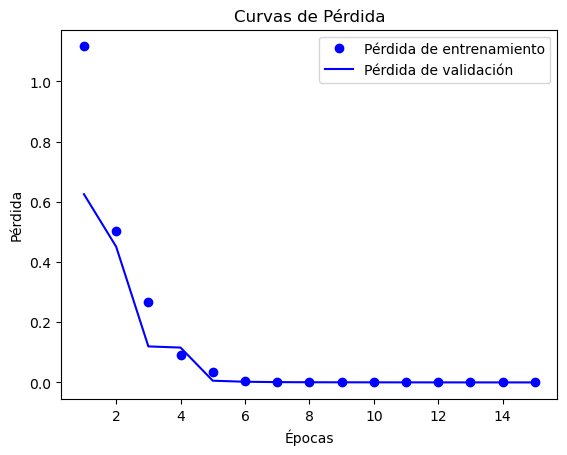

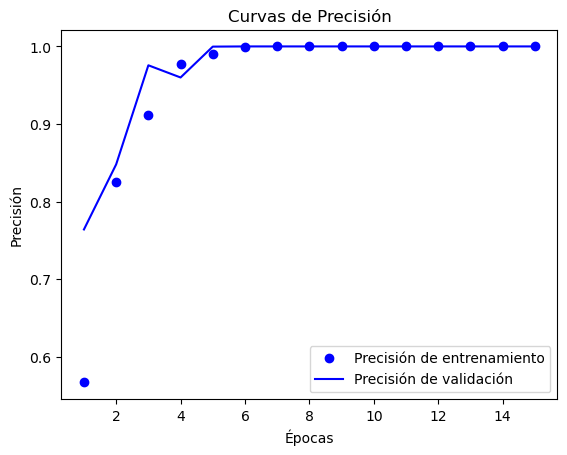

In [14]:
import matplotlib.pyplot as plt

# Obtener la pérdida y la precisión del historial de entrenamiento
pérdida = historial_entrenamiento.history['loss']
precisión = historial_entrenamiento.history['accuracy']
val_pérdida = historial_entrenamiento.history['val_loss']
val_precisión = historial_entrenamiento.history['val_accuracy']

# Visualizar las curvas de pérdida y precisión
épocas = range(1, len(pérdida) + 1)
plt.plot(épocas, pérdida, 'bo', label='Pérdida de entrenamiento')
plt.plot(épocas, val_pérdida, 'b', label='Pérdida de validación')
plt.title('Curvas de Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

plt.plot(épocas, precisión, 'bo', label='Precisión de entrenamiento')
plt.plot(épocas, val_precisión, 'b', label='Precisión de validación')
plt.title('Curvas de Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()


# Entrenamiento con VGG16

In [18]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Función para reducir el learning rate en cada época
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

# Crear el callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=5,          # Número de épocas sin mejora para detener el entrenamiento
    verbose=1,           # Muestra mensajes en la salida estándar
    restore_best_weights=True  # Restaurar los pesos del modelo en su mejor punto
)

# Crear el callback LearningRateScheduler
lr_scheduler = LearningRateScheduler(scheduler)

# Cargar el modelo VGG16 
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas superiores
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)  



In [17]:
# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Entrenar el modelo con los callbacks
model.fit(
    X_train_res, 
    y_train_res, 
    epochs=10, 
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler]  # Agregar los callbacks aquí
)

Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 408s 3s/step - accuracy: 0.8209 - loss: 0.3981 - val_accuracy: 0.9208 - val_loss: 0.2234 - learning_rate: 0.0010
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 399s 3s/step - accuracy: 0.8560 - loss: 0.3359 - val_accuracy: 0.9052 - val_loss: 0.2863 - learning_rate: 0.0010
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 400s 3s/step - accuracy: 0.8368 - loss: 0.3724 - val_accuracy: 0.8979 - val_loss: 0.3038 - learning_rate: 0.0010
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.


In [19]:

# Evaluar el modelo
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calcular las métricas
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Baloncesto', 'Campo de Futbol', 'Cancha de Golf', 'Cancha de Multiple', 'Parque','Tenis']))

30/30 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step
Precision: 0.9214156231832715
Recall: 0.9208333333333333
F1 Score: 0.9206683904575202
Accuracy: 0.9208333333333333
Classification Report:
                    precision    recall  f1-score   support

        Baloncesto       0.84      0.82      0.83       164
   Campo de Futbol       0.92      0.90      0.91       142
    Cancha de Golf       1.00      0.99      1.00       156
Cancha de Multiple       0.88      0.96      0.92       182
            Parque       0.96      0.96      0.96       169
             Tenis       0.94      0.88      0.91       147

          accuracy                           0.92       960
         macro avg       0.92      0.92      0.92       960
      weighted avg       0.92      0.92      0.92       960



# Modelo Preentrenado Xception con ImageNet

In [21]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Función para reducir el learning rate en cada época
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

# Crear el callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=5,          # Número de épocas sin mejora para detener el entrenamiento
    verbose=1,           # Muestra mensajes en la salida estándar
    restore_best_weights=True  # Restaurar los pesos del modelo en su mejor punto
)

# Crear el callback LearningRateScheduler
lr_scheduler = LearningRateScheduler(scheduler)

# Cargar el modelo Xception 
base_model = Xception(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas superiores
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)  



In [22]:
# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con los callbacks
model.fit(
    X_train_res, 
    y_train_res, 
    epochs=10, 
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler]  # Agregar los callbacks aquí
)


Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 344s 3s/step - accuracy: 0.6058 - loss: 3.2495 - val_accuracy: 0.8010 - val_loss: 0.5345 - learning_rate: 0.0010
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 346s 3s/step - accuracy: 0.7576 - loss: 0.6795 - val_accuracy: 0.8594 - val_loss: 0.4300 - learning_rate: 0.0010
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 345s 3s/step - accuracy: 0.8113 - loss: 0.5222 - val_accuracy: 0.8635 - val_loss: 0.3829 - learning_rate: 0.0010
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 350s 3s/step - accuracy: 0.8215 - loss: 0.5221 - val_accuracy: 0.8938 - val_loss: 0.3161 - learning_rate: 0.0010
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 353s 3s/step - accuracy: 0.8385 - loss: 0.4462 - val_accuracy: 0.9104 - val_loss: 0.2693 - learning_rate: 0.0010
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 352s 3s/step - accuracy: 0.8422 - loss: 0.4168 - val_accuracy: 0.9062 - val_loss: 0.2908 - learning_rate: 9.0484e-04
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 351s 3s/step - accuracy: 0.8640 - loss

In [23]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

# Evaluar el modelo
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calcular las métricas
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Baloncesto', 'Campo de Futbol', 'Cancha de Golf', 'Cancha de Multiple', 'Parque','Tenis']))

30/30 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step
Precision: 0.9283237306698808
Recall: 0.925
F1 Score: 0.9245908151171525
Accuracy: 0.925
Classification Report:
                    precision    recall  f1-score   support

        Baloncesto       0.90      0.79      0.84       164
   Campo de Futbol       0.98      0.92      0.95       142
    Cancha de Golf       1.00      1.00      1.00       156
Cancha de Multiple       0.83      0.97      0.89       182
            Parque       0.94      0.98      0.96       169
             Tenis       0.95      0.89      0.92       147

          accuracy                           0.93       960
         macro avg       0.93      0.92      0.93       960
      weighted avg       0.93      0.93      0.92       960



# Entrenamiento con MobileNet Preentrenado con Imagenet

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score

# Configuraciones
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
batch_size = 32
learning_rate = 0.001
patience = 5  # Paciencia para EarlyStopping

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Definir transformaciones (si no lo hiciste en tu preprocesamiento)
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convertir de numpy array a PIL image
    transforms.ToTensor(),  # Convertir de PIL image a tensor
])

# Convertir las etiquetas a LongTensor
train_dataset = CustomDataset(X_train_res, y_train_res.astype(int), transform=transform)
test_dataset = CustomDataset(X_test, y_test.astype(int), transform=transform)

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [13]:
# Cargar el modelo MobileNet preentrenado
model = models.mobilenet_v2(pretrained=True)

# Reemplazar la última capa del modelo para adaptarse a nuestro número de clases (6 en este caso)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 6)

model = model.to(device)


In [14]:
# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Early stopping variables
best_loss = np.Inf
epochs_no_improve = 0
early_stop = False

In [15]:
# Entrenamiento del modelo
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
        
        optimizer.zero_grad()  # Limpiar gradientes
        
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calcular pérdida
        loss.backward()  # Backward pass
        optimizer.step()  # Actualizar pesos
        
        running_loss += loss.item()
    
    # Calcular la pérdida media
    epoch_loss = running_loss / len(trainloader)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss}')
    
    # Validación
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss /= len(testloader)
    print(f'Validation Loss: {val_loss}')
    
    # Scheduler
    scheduler.step(val_loss)
    
    # Early Stopping
    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print('Early stopping triggered')
        early_stop = True
        break

    if early_stop:
        break


Epoch 1, Loss: 0.48987568283994354
Validation Loss: 0.18651045536001523
Epoch 2, Loss: 0.21118957796434482
Validation Loss: 0.1399194864400973
Epoch 3, Loss: 0.18792705828954856
Validation Loss: 0.15436893201743562
Epoch 4, Loss: 0.15297991750882037
Validation Loss: 0.14086630558595062
Epoch 5, Loss: 0.13295199344828423
Validation Loss: 0.12827862029274303
Epoch 6, Loss: 0.09375235535797753
Validation Loss: 0.10507260621525347
Epoch 7, Loss: 0.07809843764370007
Validation Loss: 0.10374259299909075
Epoch 8, Loss: 0.08993720801381935
Validation Loss: 0.1596852149348706
Epoch 9, Loss: 0.05971066982883419
Validation Loss: 0.06991205567804476
Epoch 10, Loss: 0.05033852032671172
Validation Loss: 0.08491464731826757


In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

model.eval()  # Modo de evaluación

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())  # Mover los datos a la CPU y agregarlos a la lista
        all_preds.extend(predicted.cpu().numpy())  # Mover los datos a la CPU y agregarlos a la lista

# Calcular las métricas
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Accuracy: {accuracy * 100:.5f}%')
print(f'Precision: {precision:.5f}')
print(f'Recall: {recall:.5f}')
print(f'F1 Score: {f1:.5f}')

Accuracy: 97.60417%
Precision: 0.97627
Recall: 0.97604
F1 Score: 0.97599


In [17]:
# Guardar el modelo completo
torch.save(model, 'C:/Users/nicol/Desktop/Mixto_mobileNET.pth')

# Entrenamiento con Resnet18 Preentrenado con Imagenet

In [34]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Configuraciones
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
batch_size = 32
learning_rate = 0.001
patience = 3  # Paciencia para EarlyStopping

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Definir transformaciones (si no lo hiciste en tu preprocesamiento)
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convertir de numpy array a PIL image
    transforms.ToTensor(),  # Convertir de PIL image a tensor
])


# Convertir las etiquetas a LongTensor
train_dataset = CustomDataset(X_train_res, y_train_res.astype(int), transform=transform)
test_dataset = CustomDataset(X_test, y_test.astype(int), transform=transform)

trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [35]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Cargar el modelo ResNet-18 preentrenado
model = models.resnet18(pretrained=True)

# Congelar todas las capas del modelo base
for param in model.parameters():
    param.requires_grad = False

# Modificar la última capa para que coincida con el número de clases
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 6) 

# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [36]:
# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Early stopping variables
best_loss = np.Inf
epochs_no_improve = 0
early_stop = False

c:\Users\nicol\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [37]:
# Entrenamiento del modelo
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
        
        optimizer.zero_grad()  # Limpiar gradientes
        
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calcular pérdida
        loss.backward()  # Backward pass
        optimizer.step()  # Actualizar pesos
        
        running_loss += loss.item()
    
    # Calcular la pérdida media
    epoch_loss = running_loss / len(trainloader)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss}')
    
    # Validación
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss /= len(testloader)
    print(f'Validation Loss: {val_loss}')
    
    # Scheduler
    scheduler.step(val_loss)
    
    # Early Stopping
    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print('Early stopping triggered')
        early_stop = True
        break

    if early_stop:
        break


Epoch 1, Loss: 1.0784333280978664
Validation Loss: 0.7012416293223699
Epoch 2, Loss: 0.642816353709467
Validation Loss: 0.5628473947445551
Epoch 3, Loss: 0.515772576894491
Validation Loss: 0.4988289803266525
Epoch 4, Loss: 0.4553863653732884
Validation Loss: 0.44748625457286834
Epoch 5, Loss: 0.427900165920296
Validation Loss: 0.4456703394651413
Epoch 6, Loss: 0.38434841459797275
Validation Loss: 0.4019481211900711
Epoch 7, Loss: 0.3688459528550025
Validation Loss: 0.37181838750839236
Epoch 8, Loss: 0.3540635966966229
Validation Loss: 0.36021388123432796
Epoch 9, Loss: 0.3351176048238431
Validation Loss: 0.3695579265554746
Epoch 10, Loss: 0.3238465453708364
Validation Loss: 0.3493264918526014


In [38]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

model.eval()  # Modo de evaluación

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())  # Mover los datos a la CPU y agregarlos a la lista
        all_preds.extend(predicted.cpu().numpy())  # Mover los datos a la CPU y agregarlos a la lista

# Calcular las métricas
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Accuracy: {accuracy * 100:.5f}%')
print(f'Precision: {precision:.5f}')
print(f'Recall: {recall:.5f}')
print(f'F1 Score: {f1:.5f}')



Accuracy: 88.64583%
Precision: 0.88607
Recall: 0.88646
F1 Score: 0.88553
